In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import re
import seaborn as sns
import spacy
import string
import warnings

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from gensim.corpora import Dictionary, MmCorpus
    from gensim.models import Phrases
    from gensim.models.ldamulticore import LdaMulticore
    from gensim.models.phrases import Phraser
    from gensim.models.word2vec import LineSentence

%store -r python_answers
%store -r python_answers_cleaned
%store -r python_questions
%store -r python_questions_cleaned
%store -r python_tags
%store -r python_tags_new

%store -r python_code_answer_df
%store -r python_code_questions_df

%store -r stack_answers
%store -r stack_answers_cleaned
%store -r stack_questions
%store -r stack_questions_cleaned
%store -r stack_tags
%store -r stack_tags_new

%store -r python_questions_sentences
%store -r python_answers_sentences
%store -r python_questions_sentences_cleaned_list
%store -r python_answers_sentences_cleaned_list
%store -r python_questions_sentences_cleaned_dict
%store -r python_answers_sentences_cleaned_dict
%store -r python_questions_doc_term_matrix
%store -r python_answers_doc_term_matrix
%store -r python_questions_lda
%store -r python_questions_lda_vis
%store -r python_answers_lda
%store -r python_answers_lda_vis

%store -r stack_questions_sentences
%store -r stack_answers_sentences
%store -r stack_questions_sentences_cleaned_list
%store -r stack_answers_sentences_cleaned_list
%store -r stack_questions_sentences_cleaned_dict
%store -r stack_answers_sentences_cleaned_dict
%store -r stack_questions_doc_term_matrix
%store -r stack_answers_doc_term_matrix
%store -r stack_questions_lda
%store -r stack_answers_lda
%store -r stack_questions_lda_vis
%store -r stack_answers_lda_vis

%store -r python_question_topic_df
%store -r python_answer_topic_df
%store -r stack_question_topic_df
%store -r stack_answer_topic_df

%store -r python_question_topic_df_pca
%store -r python_answer_topic_df_pca
%store -r stack_question_topic_df_pca
%store -r stack_answer_topic_df_pca

%store -r python_question_topic_df_norm
%store -r python_answer_topic_df_norm
%store -r stack_question_topic_df_norm
%store -r stack_answer_topic_df_norm

%matplotlib inline
sns.set_palette("Set3", n_colors=20, desat=.8)

In [2]:
stop_words = ['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 
              'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 
              'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 
              'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 
              'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 
              'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 
              'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 
              'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 
              'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', 
              "can't", 'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'contain', 'containing', 
              'contains', 'could', 'couldnt', 'd', 'date', 'did', "didn't", 'different', 'do', 'does', "doesn't", 'doing', 
              'done', "don't", 'down', 'downwards', 'due', 'during', 'e', 'each', 'ed', 'edu', 'effect', 'eg', 'eight', 
              'eighty', 'either', 'else', 'elsewhere', 'end', 'ending', 'enough', 'especially', 'et', 'et - al', 'etc', 
              'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'except', 'f', 'far', 
              'few', 'ff', 'fifth', 'first', 'five', 'fix', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 
              'forth', 'found', 'four', 'from', 'further', 'furthermore', 'g', 'gave', 'get', 'gets', 'getting', 'give', 
              'given', 'gives', 'giving', 'go', 'goes', 'gone', 'got', 'gotten', 'h', 'had', 'happens', 'hardly', 'has', 
              "hasn't", 'have', "haven't", 'having', 'he', 'hed', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 
              'heres', 'hereupon', 'hers', 'herself', 'hes', 'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'how', 
              'howbeit', 'however', 'hundred', 'i', 'id', 'ie', 'if', "i'll", 'im', 'immediate', 'immediately', 'importance', 
              'important', 'in', 'inc', 'indeed', 'index', 'information', 'instead', 'into', 'invention', 'inward', 'is', 
              "isn't", 'it', 'itd', "it'll", 'its', 'itself', "i've", 'j', 'just', 'k', 'keep\tkeeps', 'kept', 'kg', 'km', 
              'know', 'known', 'knows', 'l', 'largely', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 
              'lest', 'let', 'lets', 'like', 'liked', 'likely', 'line', 'little', "'ll", 'look', 'looking', 'looks', 'ltd', 
              'm', 'made', 'mainly', 'make', 'makes', 'many', 'may', 'maybe', 'me', 'mean', 'means', 'meantime', 'meanwhile', 
              'merely', 'mg', 'might', 'million', 'miss', 'ml', 'more', 'moreover', 'most', 'mostly', 'mr', 'mrs', 'much', 'mug', 
              'must', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd', 'near', 'nearly', 'necessarily', 'necessary', 
              'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nine', 'ninety', 'no', 'nobody', 'non', 
              'none', 'nonetheless', 'noone', 'nor', 'normally', 'nos', 'not', 'noted', 'nothing', 'now', 'nowhere', 'o', 
              'obtain', 'obtained', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 
              'one', 'ones', 'only', 'onto', 'oop', 'oops', 'or', 'ord', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 
              'out', 'outside', 'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part', 'particular', 'particularly', 
              'past', 'per', 'perhaps', 'placed', 'please', 'plus', 'poorly', 'possible', 'possibly', 'potentially', 'pp', 
              'predominantly', 'present', 'previously', 'primarily', 'probably', 'promptly', 'proud', 'provides', 'put', 'q', 
              'que', 'quickly', 'quite', 'qv', 'r', 'ran', 'rather', 'rd', 're', 'readily', 'really', 'recent', 'recently', 
              'ref', 'refs', 'regarding', 'regardless', 'regards', 'related', 'relatively', 'research', 'respectively', 
              'resulted', 'resulting', 'results', 'right', 'run', 's', 'said', 'same', 'saw', 'say', 'saying', 'says', 'sec', 
              'section', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sent', 'seven', 
              'several', 'shall', 'she', 'shed', "she'll", 'shes', 'should', "shouldn't", 'show', 'showed', 'shown', 'showns', 
              'shows', 'significant', 'significantly', 'similar', 'similarly', 'since', 'six', 'slightly', 'so', 'some', 
              'somebody', 'somehow', 'someone', 'somethan', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 
              'soon', 'sorry', 'specifically', 'specified', 'specify', 'specifying', 'still', 'stop', 'strongly', 'sub', 
              'substantially', 'successfully', 'such', 'sufficiently', 'suggest', 'sup', 'sure\tt', 't', 'take', 'taken', 
              'taking', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that've", 
              'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'thered', 
              'therefore', 'therein', "there'll", 'thereof', 'therere', 'theres', 'thereto', 'thereupon', "there've", 'these', 
              'they', 'theyd', "they'll", 'theyre', "they've", 'think', 'this', 'those', 'thou', 'though', 'thoughh', 'thousand', 
              'throug', 'through', 'throughout', 'thru', 'thus', 'til', 'tip', 'to', 'together', 'too', 'took', 'toward', 
              'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 
              'unless', 'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'us', 'use', 'used', 'useful', 'usefully', 
              'usefulness', 'uses', 'using', 'usually', 'v', 'value', 'various', "'ve", 'very', 'via', 'viz', 'vol', 'vols', 
              'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'way', 'we', 'wed', 'welcome', "well", "we'll", 'went', 'were', 'werent', 
              "we've", 'what', 'whatever', "what'll", 'whats', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 
              'whereby', 'wherein', 'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'who', 
              'whod', 'whoever', 'whole', "who'll", 'whom', 'whomever', 'whos', 'whose', 'why', 'widely', 'will', 'willing', 
              'wish', 'with', 'within', 'without', 'wont', 'words', 'world', 'would', 'wouldnt', 'www', 'x', 'y', 'yes', 'yet', 
              'you', 'youd', "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves', "you've", 'z', 'zero']

python_stop_words = ['python', 'scripts', 'script', 'code', 'py', 'doesn', 'work', 'works', 'fine', 'don', 'help', 
                     'true', 'false', 'return', 'acces', 'access', 'achieve', 'add', "additional", 'advance', 'allow', 'answer', 
                     'appear', 'appreciate', 'assume', 'basically', 'break', 'case', 'change', 'check', 'clear', 
                     'complete', 'correct', 'correctly', 'create', 'current', 'currently', 'def', 'dict', 'easy', 
                     'edit', 'element', 'elif', 'empty', 'enter', 'exist', 'expect', 'explain', 'float', 'follow', 
                     'form', 'function', 'generate', 'good', 'happen', 'import', 'include', 'init', 'input', 
                     'inside', 'int', 'keep', 'large', 'learn', 'length', 'long', 'lot', 'main', 'note', 'number', 
                     'open', 'option', 'original', 'output',  'place', 'pretty', 'previous', 'print', 'problem', 
                     'proces', 'process', 'program', 'project', 'provide', 'raise', 'range', 'read', 'reason', 
                     'receive', 'remove', 'require', 'response', 'result', 'second', 'select', 'send', 'separate', 
                     'simple', 'solution', 'solve', 'specific', 'start', 'suggestion', 'suppose', 'sure', 'template', 
                     'test', 'three', 'type', 'unable', 'understand', 'var', 'variable', 'version', 'view', 'wonder', 
                     'wrong', 'accomplish', 'accord', 'action', 'actual', 'alternative', 'area', 'amount', 'age', 
                     'attempt', 'automatically', 'avoid', 'bad', 'base', 'big', 'build', 'bunch', 'calculate', 'call', 
                     'char', 'clas', 'close', 'collect', 'combine', 'comment', 'completely', "complex", "compute", 
                     'computer', "configure", "config", "confused", "consider", "continue", "day", "deal", "definition", 
                     "description", "desire", "detail", "dev", "difference", "dir", "directly", "double", "draw", "dynamically", 
                     "easily", "enable", "entire", "environment", "env", "equal", "essentially", "exactly", "face", "fact", "fail", 
                     "feel", "fill", "finally", "find", "finish", "foo", "force", "full", "func", "future", "general", "global", 
                     "goal", "great", "greatly", "hand", "hard", "hello", "high", "hint", "hold", "hope", "hop", "hour", "idea", 
                     "ignore", "img", "implement", "increase", "info", "init__.py", "initial", "instal", "installation", "interested", 
                     "issue", "iteration", "job", "kind", "late", "leave", "left", "letter", "lib", "limit", "list", "load", 
                     "local", "locally", "locate", "loop", "lose", "low", "manage", "manage.py", "manager", "manually", 
                     "map", "match", "matter", "max", "mention", "min", "mind", "minute", "models.py", "moment", "month", 
                     "move", "multi", "newbie", "nice", "notice", "null", "num", "obj", "occur", "online", "operation", 
                     "oth", "package", "param", "pas", "people", "perfectly", "performance", "piece", "play", 
                     "post", "practice", "prefer", "pres", "prevent", "price", "programming", "properly", "purpose", 
                     "question", "raw", "real", "realize", "recognize", "record", "red", "regard", "regular", "relate", 
                     "report", "resolve", "rest", "save", "self.name", "sense", "set", "setup.py", "share", "short", 
                     "side", "sign", "signal", "simply", "single", "size", "small", "slow", "socket.socket", "special", 
                     "src", "state", "statu", "step", "str", "strange", "stuck", "stuff", "succes", "switch", "tab", 
                     "temp", "term", "Testing", "thing", "third", "throw", "title", "tool", "top", "total", "trouble", "turn", 
                     "user", "usr", "views.py", "wait", "warning", "week", "weird", "win", "windows", "word", "wrap", "write", 
                     "year", "yield"]

additional_stop_words = ['.__init', '.append', '.csv', '.encode', '.format', '.grid', '.html', '.join', '.jpg', '.png', 
                         '.read', '.split', 'abc', 'accept', 'advice', 'append', 'application', 'apply', 'arg', 'args', 
                         'argument', 'attribute', 'character', 'class', 'command', 'convert', 'count', 'datum', 'decide', 
                         'define', 'error', 'example', 'explanation', 'file', 'filter', 'fortunately', 'happy', 'http', 'indicate', 
                         'install', 'instance', 'integer', 'item', 'key', 'label', 'lambda', 'len', 'library', 'luckily', 'lucky', 
                         'message', 'method', 'multiple', 'object', 'order', 'pass', 'point', 'pull', 'quick', 'sad', 'sadly', 'search', 
                         'string', 'sum', 'task', 'text', 'thread', 'time', 'understanding', 'update', 'valid', 'window', 'google', 
                         'helpful', 'definitely', 'array', 'column', 'row']

# python_stop_words.remove("python")
stop_words.extend(python_stop_words)
stop_words.extend(additional_stop_words)

TOTAL_STOP_WORDS = frozenset(stop_words)
nlp = spacy.load("en")

In [3]:
def converting_token_to_bigram_sentences(df, col):
    unigram_sentences = list(df[col].apply(tokenize))
    bigram_model = Phrases(unigram_sentences)
    bigram_model_phraser = Phraser(bigram_model)
    return list(bigram_model_phraser[unigram_sentences])
    
def converting_token_to_trigram_sentences(df, col):
    bigram_sentences = converting_token_to_bigram_sentences(df, col)
    trigram_model = Phrases(bigram_sentences)
    trigram_model_phraser = Phraser(trigram_model)
    return list(trigram_model_phraser[bigram_sentences])

def count_line_of_code(text):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bs = BeautifulSoup(text)
        if(bs.pre is None): return 0
        count = str(bs.pre).count("\n")
        if count == 0: return 1
        else: return count

def extra_cleaning(text):
    new_text = re.sub("(&lt;)+|(&gt;)+|(i\.e\.)+|(e\.g\.)+", "", text)
    return new_text

def find_top_n_import(df, n, ax = None, color = "#074484"):
    pattern = re.compile(r'(from\s([^\s]+)\simport\s([^\s]+)|import\s([^\s]+))')
    sample_text_import = df["Code Body"].str.extractall(pattern)[0]
    sample_text_import_count = sample_text_import.value_counts()
    sample_text_import_count_df = pd.DataFrame(sample_text_import_count, index=sample_text_import_count.index, columns=["Count"])
    if(ax == None): return sns.barplot(y=sample_text_import_count_df.iloc[0:n].index,
            x=sample_text_import_count_df.iloc[0:n].Count, 
            data=sample_text_import_count_df.iloc[0:n],
            color=color)
    else: return sns.barplot(y=sample_text_import_count_df.iloc[0:n].index,
            x=sample_text_import_count_df.iloc[0:n].Count, 
            data=sample_text_import_count_df.iloc[0:n],
            color=color, ax = ax)

def get_clusters(X, index, n_cluster, batch_size=1000, series_name='clusters', random_state=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if(random_state == None):
            random = np.random.randint(1, 100000)
            model = MiniBatchKMeans(n_clusters=n_cluster, init='k-means++', batch_size=batch_size, random_state=random).fit(X)
        else:
            model = MiniBatchKMeans(n_clusters=n_cluster, init='k-means++', batch_size=batch_size, random_state=random_state).fit(X)
        print(model)
        labels = list(map(lambda x: "Cluster " + str(x) ,list(model.labels_)))
        return pd.Series(labels, index=index, name=series_name)
    
def get_clusters_new(X, df, n_cluster, n_repeat):
    clusterer = nltk.cluster.KMeansClusterer(n_cluster, nltk.cluster.util.cosine_distance, repeats=n_repeat, avoid_empty_clusters=True)
    clusterer.cluster(X)
    clusters = {}
    df_matrix = df.as_matrix()
    for index in df.index:
        clusters[index] = "Cluster " + str(clusterer.classify(df_matrix[index]))
    return pd.Series(clusters, index=df.index)
    
def get_lemmatized_word(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token.lemma_)
    return tokens[0]
    
def get_top_n_qns_from_cluster_m(df, cluster, num = 10):
    temp_df = df[df["Cluster"] == cluster]
    temp_df = temp_df.sort_values("Tf-idf Score", ascending=False)
    return temp_df[["Cluster", "Title", "Text for Analysis (Title + Body Exc. Code)", "Tf-idf Score"]].head(num)

def get_topic_distribution(lda, dtm):
    dic = {}
    for index, item in enumerate(python_questions_lda[python_questions_doc_term_matrix]):
        temp_dic = {}
        for pair in item:
            temp_dic[pair[0]] = pair[1]
        dic[index] = temp_dic
    df = pd.DataFrame.from_dict(dic).T
    return df.reindex_axis(sorted(df.columns), axis=1)

def get_tsne_from_dtm(dtm, dtm_df):
    tsne = TSNE(n_components=2, random_state=0, metric="cosine")
    if dtm_df.shape[1] <= 10000:
        dtm_tsne = tsne.fit_transform(dtm.toarray())
    else:
        n_components_pca = 10000
        dtm_tsne = tsne.fit_transform(PCA(n_components=n_components_pca, random_state=0).fit_transform(dtm.toarray()))
    return dtm_tsne

def get_pca(df):
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df)
    df_pca_df = pd.DataFrame(df_pca)
    df_pca_df.columns = ["x", "y"]
    return df_pca_df

def get_word_count_from_df(df):
    qns_word = df["Body Word Count"].value_counts()
    qns_word.index = df["Body Word Count"].value_counts().index.astype(str)
    qns_word = pd.DataFrame(qns_word).reset_index()
    qns_word.columns = ["Word Count", "Occurences"]
    qns_word["Word Count"] = qns_word["Word Count"].apply(lambda x: x + "w")
    qns_word.set_index("Word Count", inplace=True)
    return qns_word

def is_valid_word(string):
    if(len(string) < 2): return False
    else:
        first_char = string[0]
        time = 1
        for char in string[1:]:
            if(char == first_char): time+= 1
            else: time = 0
            if(time >= 3): return False
    return True

def plot_score_title_body_length(df):
    questions_title_length = df["Title"].apply(lambda x: len(x))
    questions_body_length = df["Body"].apply(lambda x: len(x))
    fig, ax = plt.subplots(ncols=3, nrows=1)
    fig.set_size_inches(11.7, 4)
    sns.distplot(df[(df.Score <= 50) & (df.Score >= -20)].Score, ax=ax[0], color="#074484", kde=False)
    sns.distplot(questions_title_length, ax=ax[1], color="#074484", kde=False)
    sns.distplot(questions_body_length[questions_body_length < 10000], ax=ax[2], color="#074484", kde=False)
    
def print_original_and_tokenized(text_series, index=-1):
    if(index == -1): index = np.random.randint(0, text_series.shape[0])
    print("Current index: %.d" % index + "\n")
    print("Original: " + text_series.iloc[index] + "\n")
    print("Tokenized: " + str(list(tokenize(text_series.iloc[index]))) + "\n")
    print("Finalized: " + str(list(tokenize_n_grams(text_series.iloc[index]))) + "\n")
    print("After Removing Stop Words: " + str(remove_stop_words(text_series.iloc[index])))

def reading_and_preprocessing(filepath):
    df = pd.read_csv(filepath, encoding="latin1")
    lst_of_cols = list(df.columns)
    df["CreationDate"] = df["CreationDate"].apply(lambda x: pd.to_datetime(x))
    if("Title" in lst_of_cols): df["Title"] = df["Title"].apply(lambda x: str(x))
    df["Body"] = df["Body"].apply(lambda x: str(x))
    df.set_index("Id", inplace=True)
    return df[(df["CreationDate"] > "2008-10-14 23:59:59") & (df["CreationDate"] < "2016-10-13 00:00:00")]  
    
def remove_stop_words(text):
    text_token = list(filter(lambda x: x not in TOTAL_STOP_WORDS, tokenize_n_grams(text)))
    return text_token
    
def return_code_body(text):
    pattern = re.compile(r'<[^>]+>|\n|\r')
    soup = BeautifulSoup(text, 'html.parser')
    return pattern.sub(" ", str(soup.pre))

def return_code_df(df):
    return pd.DataFrame(df["Body"].apply(lambda x: return_code_body(x)).apply(lambda y: extra_cleaning(y)))

def return_normalized_df(df):
    return pd.DataFrame(normalize(df), index=df.index, columns=df.columns)

def return_top_n_words(dtm_df, cluster, cluster_df, n):
    new_df = dtm_df.join(pd.DataFrame(dtm_df.sum(axis=1), columns=["Tf-idf Score"], index=dtm_df.index))
    new_df["cluster"] = cluster_df
    lst = list(new_df.loc[new_df["cluster"] == cluster].drop("cluster", axis=1).sum().sort_values(ascending=False).index[2:])
    if(len(lst) > n): print(" ".join(lst[:n]))
    else: print(" ".join(lst))
        
def return_top_n_topics_in_cluster(topic_lda, topic_df, cluster_df, cluster_index, top_n=5):
    top_topic = topic_df[topic_df.index.isin(cluster_df[cluster_df=="Cluster "+str(cluster_index)].index)]
    top_topic_sorted = top_topic.mean().sort_values(ascending=False)[:top_n]
    for index in top_topic_sorted.index:
        print(list(map(lambda x: x[0], topic_lda.show_topic(index))))
        
def return_word_count(text):
    return len(list(filter(lambda x: x not in string.punctuation, re.findall("(\S+)", text))))

def sampling_clean_text(df, num_of_samples = None):   
    if(num_of_samples != None): test_code = df.sample(n=num_of_samples)
    else: test_code = df.copy()
    test_code["Code Body"] = test_code["Body"].apply(lambda x: return_code_body(x)).apply(lambda y: extra_cleaning(y))
    test_code["Body Exc. Code"] = test_code["Body"].str.replace(r'<pre>([a]|[^a])+</pre>'," ").str.replace(r"<[^>]+>|\n|\r", " ").str.replace(r"(http\S+)|(www\.\S+)|(\S+\.com)", " ")
    test_code["Body Exc. Code"] = test_code["Body Exc. Code"].apply(lambda x: extra_cleaning(x))
    if("Title" in list(test_code.columns)): 
        test_code["Text for Analysis (Title + Body Exc. Code)"] = test_code["Title"].str.cat(test_code["Body Exc. Code"], sep = " ")
        test_code["Full Body (Title + Body + Code)"] = test_code["Text for Analysis (Title + Body Exc. Code)"].str.cat(test_code["Code Body"], sep = " ")
    return test_code.reindex_axis(sorted(test_code.columns), axis=1)

def tokenize(text):
    text = text.lower()
    text_new = ""
    stop_word = ["-PRON-", "_", ".", "'", "'s", ".py", ".txt"]
    word_list = ["os", "app", "api", "amp", "csv", "gui", "mac", "sql", "web", "xml", "url"]
    for ch in text:
        if ((ch not in '!"#$%&\()*+,-/:;<=>?@[\\]^`{|}~') & (ch not in "âÂ0123456789") & (ch != "")): 
            text_new += ch
        else: text_new += " "
    doc = nlp(text_new)
    tokens = []
    for token in doc:
        if (" " not in token.lemma_) & ("    " not in token.lemma_): 
            if(is_valid_word(token.lemma_) == False): continue
            if((token.lemma_ not in stop_word) & (len(token.lemma_) > 3) & (".." not in token.lemma_)): tokens.append(token.lemma_)
            if((len(token.lemma_) <= 3) & (token.lemma_ in word_list)): tokens.append(token.lemma_)
    tokens = list(filter(lambda x: (bool(re.match(r'(\.\w+)', x)) == False) & 
                         (bool(re.match(r'(www\.\S+)', x)) == False), tokens))
    return tokens

def tokenize_n_grams(text):
    tokens = tokenize(text)
    new_tokens = []
    for token in tokens:
        contain_multiple_stop_words = False
        count = 0
        if "_" in token:
            word_lst = token.split("_")
            for word in word_lst:
                if (word in TOTAL_STOP_WORDS) | (word in LEMMA_STOP_WORDS): count += 1
            if count >= 2: contain_multiple_stop_words = True
            if not contain_multiple_stop_words: new_tokens.append(token)
        else: new_tokens.append(token)
    return new_tokens

LEMMA_STOP_WORDS = list(filter(lambda x: x != "-PRON-", map(get_lemmatized_word, TOTAL_STOP_WORDS)))

# 1. Reading Data, Exploring and Preprocessing

In [4]:
# python_questions = reading_and_preprocessing("./pythonquestions/Questions.csv")
# python_answers = reading_and_preprocessing("./pythonquestions/Answers.csv")
# python_tags = pd.read_csv("./pythonquestions/Tags.csv")
# stack_questions = reading_and_preprocessing("./stacksample/Questions.csv")
# stack_answers = reading_and_preprocessing("./stacksample/Answers.csv")
# stack_tags = pd.read_csv("./stacksample/Tags.csv")

In [5]:
print("Python Answers: " + str(python_answers.shape))
print("Python Questions: " + str(python_questions.shape))
print("Python Tags: " + str(python_tags.shape))
print("Python Tags (Aggregated): " + str(python_tags_new.shape))
print()
print("StackOverflow Sample Answers: " + str(stack_answers.shape))
print("StackOverflow Sample Questions: " + str(stack_questions.shape))
print("StackOverflow Sample Tags: " + str(stack_tags.shape))
print("StackOverflow Tags (Aggregated): " + str(stack_tags_new.shape))

Python Answers: (979544, 5)
Python Questions: (602869, 5)
Python Tags: (1885078, 2)
Python Tags (Aggregated): (607283, 2)

StackOverflow Sample Answers: (1997427, 5)
StackOverflow Sample Questions: (1255956, 6)
StackOverflow Sample Tags: (3750994, 2)
StackOverflow Tags (Aggregated): (1264216, 2)


# 1.1. Python Dataset

## 1.1.1. Python Questions

In [6]:
python_questions.head(3)

,OwnerUserId,CreationDate,Score,Title,Body
Id,,,,,
203487,5646.0,2008-10-15 02:00:27,19,Creating self-contained python applications,<p>I'm trying to create a self-contained versi...
203758,115.0,2008-10-15 04:55:33,2,Receive socket size limits good?,<p>I am writing a program in Python that will ...
203859,432.0,2008-10-15 06:22:22,2,"How do I get python-markdown to additionally ""...",<p>Markdown is a great tool for formatting pla...


In [7]:
# python_questions_cleaned = sampling_clean_text(python_questions)
# python_questions_body_word_count = python_questions_cleaned["Body Exc. Code"].apply(return_word_count)
# python_questions_cleaned["Body Word Count"] = python_questions_body_word_count
# python_questions_lines_of_code = python_questions_cleaned["Body"].apply(lambda x: count_line_of_code(x))
# python_questions_cleaned["Lines of Code"] = python_questions_lines_of_code
python_questions_cleaned.head()

,Body,Body Exc. Code,CreationDate,OwnerUserId,Score,Text for Analysis (Title + Body Exc. Code),Title,Body Word Count,Lines of Code
Id,,,,,,,,,
203487,<p>I'm trying to create a self-contained versi...,I'm trying to create a self-contained version...,2008-10-15 02:00:27,5646.0,19,Creating self-contained python applications I...,Creating self-contained python applications,78,0
203758,<p>I am writing a program in Python that will ...,I am writing a program in Python that will ac...,2008-10-15 04:55:33,115.0,2,Receive socket size limits good? I am writing...,Receive socket size limits good?,78,0
203859,<p>Markdown is a great tool for formatting pla...,Markdown is a great tool for formatting plain...,2008-10-15 06:22:22,432.0,2,"How do I get python-markdown to additionally ""...","How do I get python-markdown to additionally ""...",41,0
203912,<p>What is the difference between multiprocess...,What is the difference between multiprocessor...,2008-10-15 06:59:50,20211.0,60,Does python support multiprocessor/multicore p...,Does python support multiprocessor/multicore p...,26,0
204017,<p>I have a python script that needs to execut...,I have a python script that needs to execute ...,2008-10-15 08:24:28,267.0,206,How do I execute a program from python? os.sys...,How do I execute a program from python? os.sys...,23,3


## 1.1.2. Python Answers

In [8]:
python_answers.head(3)

,OwnerUserId,CreationDate,ParentId,Score,Body
Id,,,,,
203332,8247.0,2008-10-15 00:31:10,202939,1,"<p>You should also take a look at <a href=""htt..."
203514,3119.0,2008-10-15 02:17:35,203487,20,"<p>Check out <a href=""http://www.pyinstaller.o..."
203679,18676.0,2008-10-15 03:54:29,202939,1,"<p>You might want to look at <a href=""http://k..."


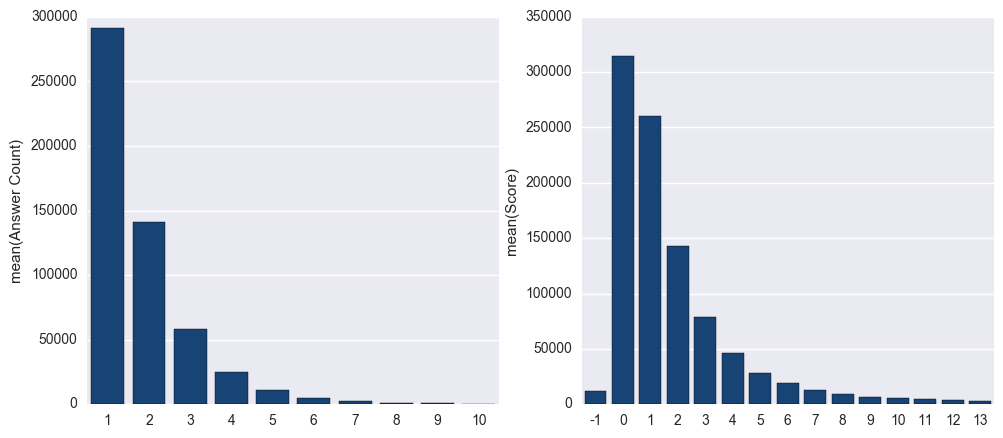

In [9]:
answer_count = pd.DataFrame(python_answers.groupby("ParentId").count()["Body"])
answer_count.columns = ["Answer Count"]
answer_count_larger = answer_count[(answer_count["Answer Count"] >= 1) & (answer_count["Answer Count"] <= 10)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=answer_count_larger["Answer Count"].value_counts(), x=answer_count_larger["Answer Count"].value_counts().index, 
            color="#074484", ax=ax[0])
sns.barplot(y=python_answers["Score"].value_counts()[:15], x=python_answers["Score"].value_counts()[:15].index, 
            color="#074484", ax=ax[1])

In [10]:
# python_answers_cleaned = sampling_clean_text(python_answers)
# python_answers_body_word_count = python_answers_cleaned["Body Exc. Code"].apply(return_word_count)
# python_answers_cleaned["Body Word Count"] = python_answers_body_word_count
# python_answers_lines_of_code = python_answers_cleaned["Body"].apply(count_line_of_code)
# python_answers_cleaned["Lines of Code"] = python_answers_lines_of_code
python_answers_cleaned.head(3)

,Body,Body Exc. Code,CreationDate,OwnerUserId,ParentId,Score,Body Word Count,Lines of Code
Id,,,,,,,,
203332,"<p>You should also take a look at <a href=""htt...",You should also take a look at web2py which...,2008-10-15 00:31:10,8247.0,202939,1,22,0
203514,"<p>Check out <a href=""http://www.pyinstaller.o...","Check out pyinstaller , it makes standalone ...",2008-10-15 02:17:35,3119.0,203487,20,15,0
203679,"<p>You might want to look at <a href=""http://k...",You might want to look at Karrigell . It has...,2008-10-15 03:54:29,18676.0,202939,1,49,0


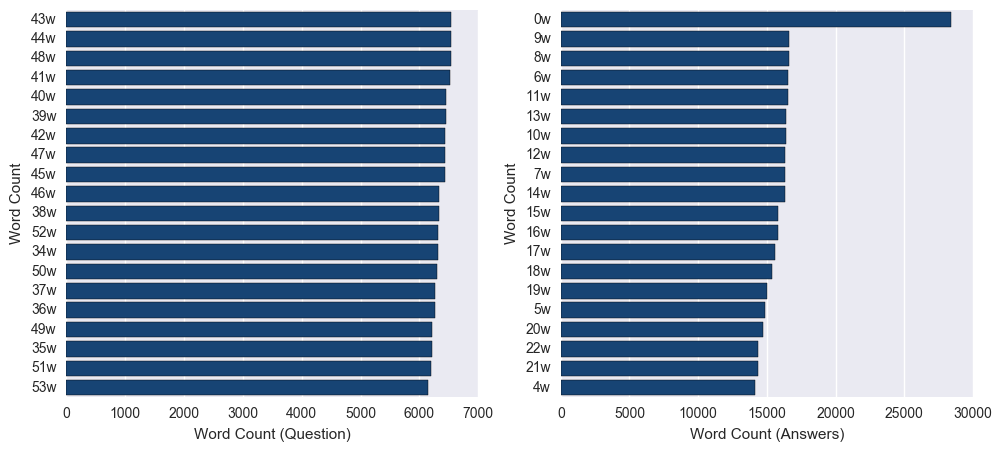

In [11]:
qns_word = get_word_count_from_df(python_questions_cleaned)
ans_word = get_word_count_from_df(python_answers_cleaned)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(x=qns_word.Occurences[:20], y=qns_word.index[:20], 
            color="#074484", ax=ax[0])
ax[0].set_xlabel("Word Count (Question)")
sns.barplot(x=ans_word.Occurences[:20], y=ans_word.index[:20], 
            color="#074484", ax=ax[1])
ax[1].set_xlabel("Word Count (Answers)")

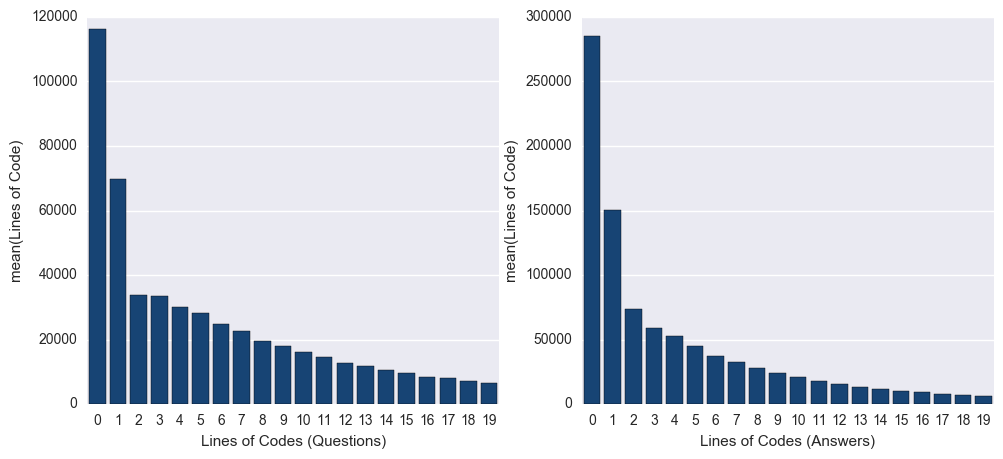

In [12]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=python_questions_cleaned["Lines of Code"].value_counts()[:20], x=python_questions_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#074484", ax=ax[0], orient="v")
ax[0].set_xlabel("Lines of Codes (Questions)")
sns.barplot(y=python_answers_cleaned["Lines of Code"].value_counts()[:20], x=python_answers_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#074484", ax=ax[1], orient="v")
ax[1].set_xlabel("Lines of Codes (Answers)")

## 1.1.3. Python Tags

In [13]:
python_tags.head(3)

,Id,Tag
0,469,python
1,469,osx
2,469,fonts


In [14]:
# python_tags["Tag"] = python_tags["Tag"].astype(str)
# python_tags_new = python_tags.groupby("Id").agg({"Tag": ["count", lambda x: ", ". join(x)]})
# python_tags_new.columns = python_tags_new.columns.get_level_values(0)
# python_tags_new.columns = ["Tag Count", "Tags"]
python_tags_new.head(3)

,Tag Count,Tags
Id,,
469,4,"python, osx, fonts, photoshop"
502,4,"python, windows, image, pdf"
535,3,"python, continuous-integration, extreme-progra..."


In [15]:
python_tags_count = pd.DataFrame(python_tags_new["Tag Count"].value_counts()).rename_axis("Tag Count").rename_axis({"Tag Count": "Occurences"}, axis="columns")
python_tags_count.head()

,Occurences
Tag Count,
3,189589
2,155095
4,133714
5,85595
1,43290


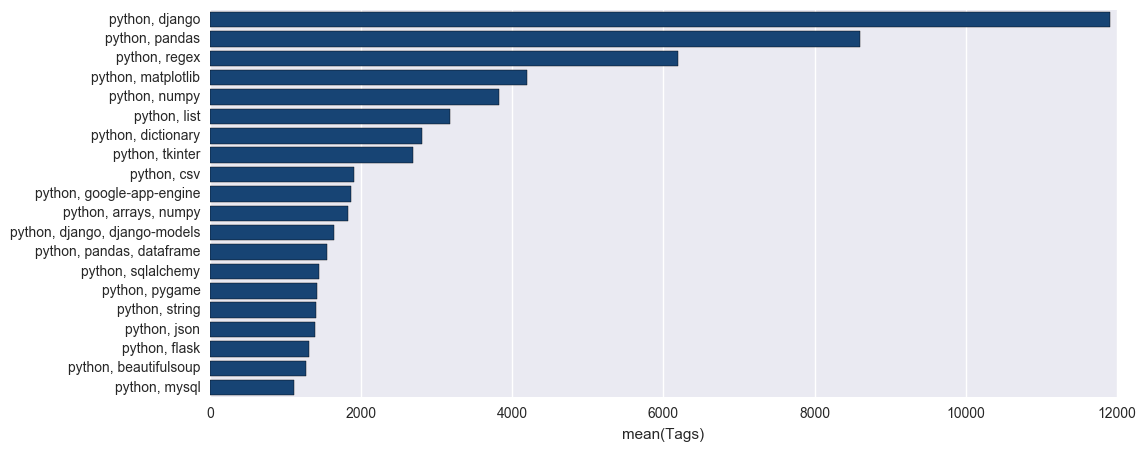

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(x=python_tags_new.loc[python_tags_new["Tags"].apply(lambda x: (", "in x) & (x.count("python") < 2)), "Tags"].value_counts()[:20], 
            y=python_tags_new.loc[python_tags_new["Tags"].apply(lambda x: (", "in x) & (x.count("python") < 2)), "Tags"].value_counts()[:20].index, 
            color="#074484", orient="horizontal")

## 1.1.4. Others

In [17]:
# python_code_answer_df = return_code_df(python_answers_cleaned).rename_axis({"Body": "Code Body"}, axis="columns")
# python_code_questions_df = return_code_df(python_questions_cleaned).rename_axis({"Body": "Code Body"}, axis="columns")

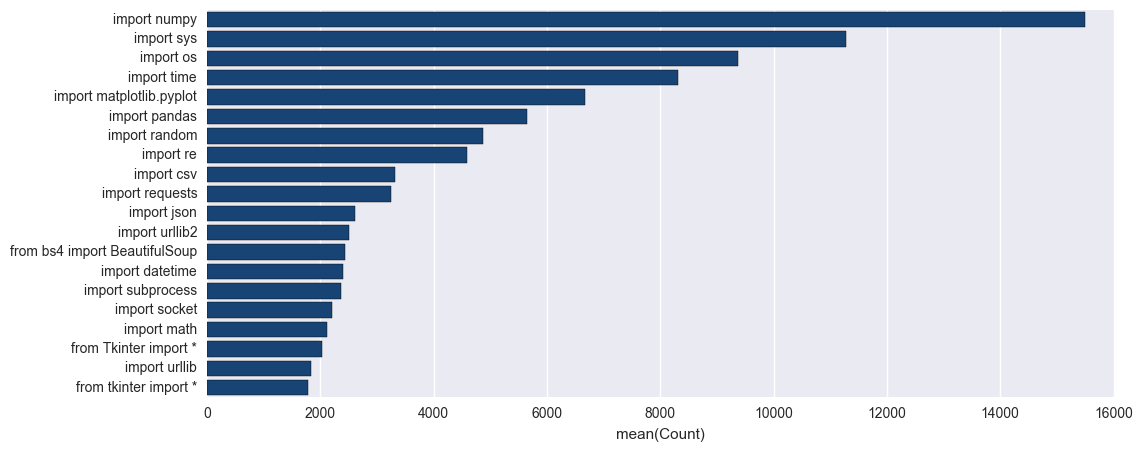

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
find_top_n_import(python_code_questions_df, 20)

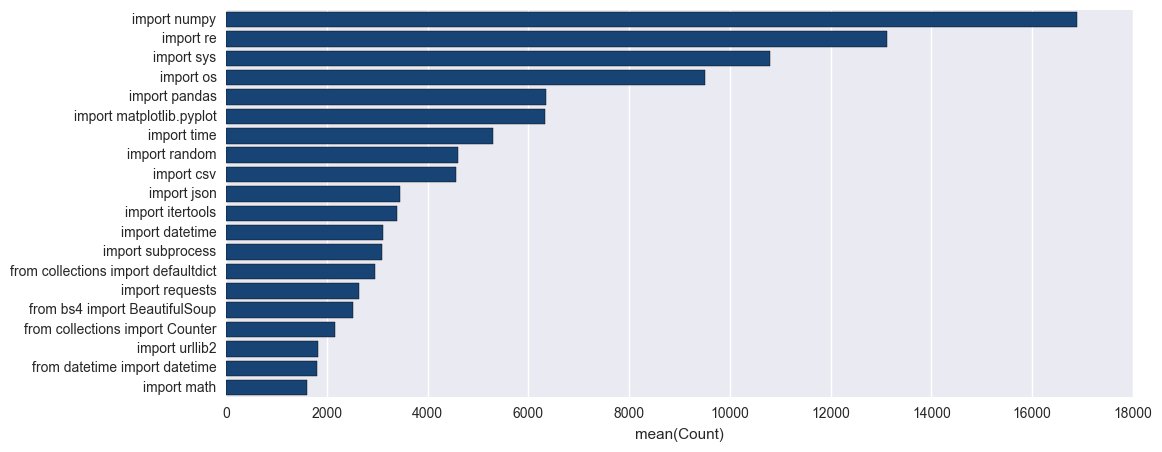

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
find_top_n_import(python_code_answer_df, 20)

# 1.2. StackOverflow 10% Sample Dataset

## 1.2.1. StackOverflow Questions

In [20]:
stack_questions.head(3)

,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
Id,,,,,,
203340,27580.0,2008-10-15 00:35:54,NaN,32,"JQuery: Current, Well-Formatted, Printable Doc...","<p>I'm looking for a current (1.2), well-forma..."
203520,5496.0,2008-10-15 02:19:28,NaN,2,How do I discriminate between data binding and...,<p>I have what must be a typical catch-22 prob...
203590,361.0,2008-10-15 03:05:53,NaN,0,Include directory in VS 2003,<p>Where is the setting in Visual Studio 2003 ...


In [21]:
# stack_questions_cleaned = sampling_clean_text(stack_questions)
# stack_questions_body_word_count = stack_questions_cleaned["Body Exc. Code"].apply(return_word_count)
# stack_questions_cleaned["Body Word Count"] = stack_questions_body_word_count
# stack_questions_lines_of_code = stack_questions_cleaned["Body"].apply(lambda x: count_line_of_code(x))
# stack_questions_cleaned["Lines of Code"] = stack_questions_lines_of_code
# stack_questions_cleaned.drop("ClosedDate", inplace=True, axis=1)
# stack_questions_cleaned.drop("Body", inplace=True, axis=1)
# stack_questions_cleaned.drop("Full Body (Title + Body + Code)", inplace=True, axis=1)
stack_questions_cleaned.head()

,Body Exc. Code,Code Body,CreationDate,OwnerUserId,Score,Text for Analysis (Title + Body Exc. Code),Title,Body Word Count,Lines of Code
Id,,,,,,,,,
203340,"I'm looking for a current (1.2), well-formatt...",None,2008-10-15 00:35:54,27580.0,32,"JQuery: Current, Well-Formatted, Printable Doc...","JQuery: Current, Well-Formatted, Printable Doc...",185,0
203520,I have what must be a typical catch-22 proble...,None,2008-10-15 02:19:28,5496.0,2,How do I discriminate between data binding and...,How do I discriminate between data binding and...,325,0
203590,Where is the setting in Visual Studio 2003 to...,None,2008-10-15 03:05:53,361.0,0,Include directory in VS 2003 Where is the set...,Include directory in VS 2003,41,0
203620,I need ideas on how to go about table layout ...,None,2008-10-15 03:25:18,28098.0,2,How to make a bilingual site without creating ...,How to make a bilingual site without creating ...,25,0
203640,"url is "" But it renders as: "" "" ...","a xsl:attribute name=""href"" xsl:value-of s...",2008-10-15 03:35:44,NaN,1,Why do my XSL transformed links come out relat...,Why do my XSL transformed links come out relat...,8,7


## 1.2.2. StackOverflow Answers

In [22]:
stack_answers.head(3)

,OwnerUserId,CreationDate,ParentId,Score,Body
Id,,,,,
203282,25688.0,2008-10-15 00:04:23,202750,5,"<p><a href=""http://en.wikipedia.org/wiki/Hyper..."
203290,18255.0,2008-10-15 00:08:28,203040,2,"<p>Firstly, it's probably not SQL Server throw..."
203326,21239.0,2008-10-15 00:29:06,202750,17,"<p><a href=""http://www.dangermouse.net/esoteri..."


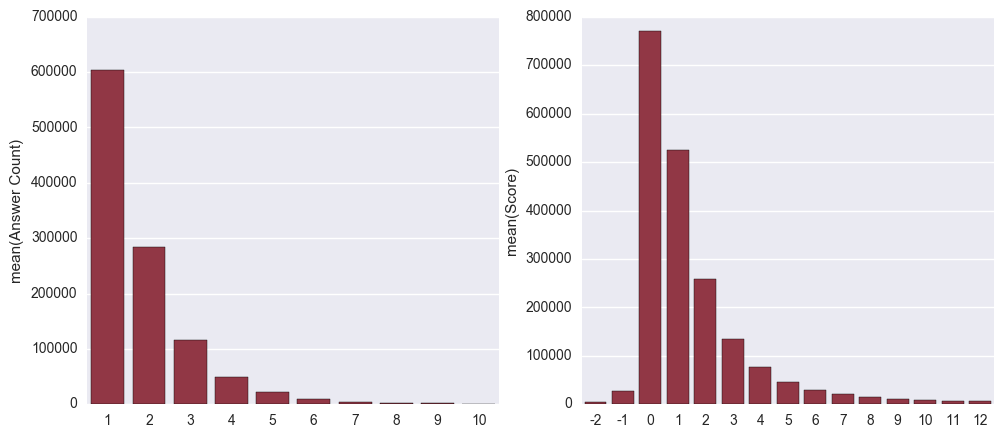

In [23]:
stack_answer_count = pd.DataFrame(stack_answers.groupby("ParentId").count()["Body"])
stack_answer_count.columns = ["Answer Count"]
stack_answer_count_larger = stack_answer_count[(stack_answer_count["Answer Count"] >= 1) & (stack_answer_count["Answer Count"] <= 10)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=stack_answer_count_larger["Answer Count"].value_counts(), x=stack_answer_count_larger["Answer Count"].value_counts().index, 
            color="#A0283A", ax=ax[0])
sns.barplot(y=stack_answers["Score"].value_counts()[:15], x=stack_answers["Score"].value_counts()[:15].index, 
            color="#A0283A", ax=ax[1])

In [24]:
# stack_answers_cleaned = sampling_clean_text(stack_answers)
# stack_answers_body_word_count = stack_answers_cleaned["Body Exc. Code"].apply(return_word_count)
# stack_answers_cleaned["Body Word Count"] = stack_answers_body_word_count
# stack_answers_lines_of_code = stack_answers_cleaned["Body"].apply(lambda x: count_line_of_code(x))
# stack_answers_cleaned["Lines of Code"] = stack_answers_lines_of_code
# stack_answers_cleaned.drop("Body", inplace=True, axis=1)
stack_answers_cleaned.head(3)

,Body Exc. Code,Code Body,CreationDate,OwnerUserId,ParentId,Score,Body Word Count,Lines of Code
Id,,,,,,,,
203282,HyperTalk and its descendant AppleScript ...,None,2008-10-15 00:04:23,25688.0,202750,5,14,0
203290,"Firstly, it's probably not SQL Server throwin...",None,2008-10-15 00:08:28,18255.0,203040,2,175,0
203326,Chef ! Anyone can read recipes right? Behold...,Ingredients. 72 g haricot beans 101 eggs 108...,2008-10-15 00:29:06,21239.0,202750,17,22,18


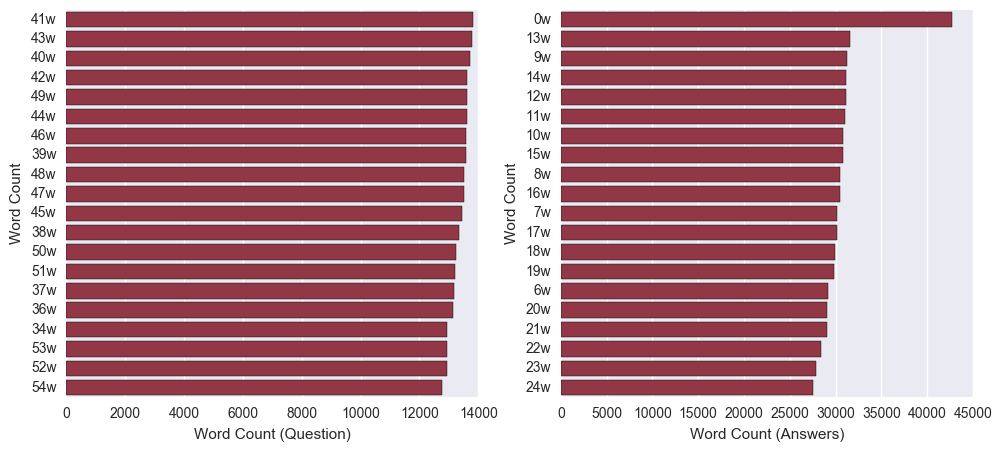

In [25]:
stack_qns_word = get_word_count_from_df(stack_questions_cleaned)
stack_ans_word = get_word_count_from_df(stack_answers_cleaned)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(x=stack_qns_word.Occurences[:20], y=stack_qns_word.index[:20], 
            color="#A0283A", ax=ax[0])
ax[0].set_xlabel("Word Count (Question)")
sns.barplot(x=stack_ans_word.Occurences[:20], y=stack_ans_word.index[:20], 
            color="#A0283A", ax=ax[1])
ax[1].set_xlabel("Word Count (Answers)")

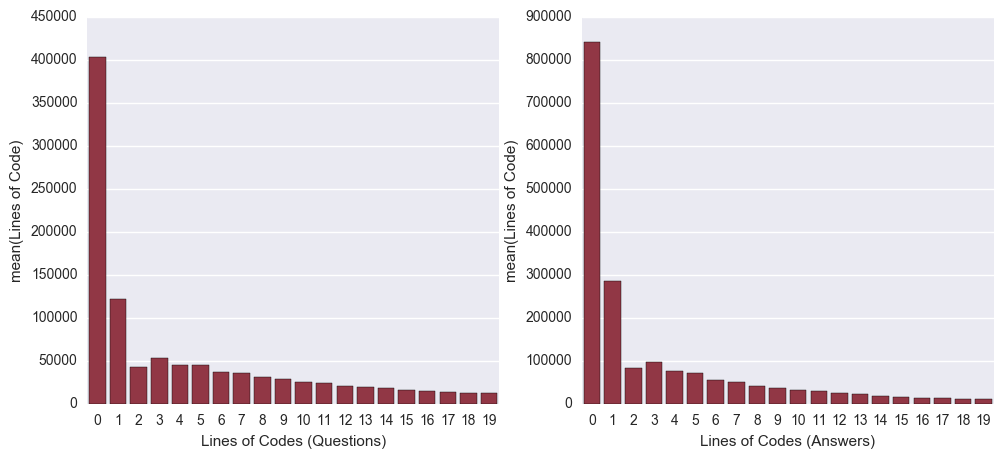

In [26]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=stack_questions_cleaned["Lines of Code"].value_counts()[:20], x=stack_questions_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#A0283A", ax=ax[0], orient="v")
ax[0].set_xlabel("Lines of Codes (Questions)")
sns.barplot(y=stack_answers_cleaned["Lines of Code"].value_counts()[:20], x=stack_answers_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#A0283A", ax=ax[1], orient="v")
ax[1].set_xlabel("Lines of Codes (Answers)")

## 1.2.3. StackOverflow Tags

In [27]:
stack_tags.head(3)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air


In [28]:
# stack_tags["Tag"] = stack_tags["Tag"].astype(str)
# stack_tags_new = stack_tags.groupby("Id").agg({"Tag": ["count", lambda x: ", ". join(x)]})
# stack_tags_new.columns = stack_tags_new.columns.get_level_values(0)
# stack_tags_new.columns = ["Tag Count", "Tags"]
stack_tags_new.head(3)

,Tag Count,Tags
Id,,
80,3,"flex, actionscript-3, air"
90,4,"svn, tortoisesvn, branch, branching-and-merging"
120,3,"sql, asp.net, sitemap"


In [29]:
stack_tags_count = pd.DataFrame(stack_tags_new["Tag Count"].value_counts()).rename_axis("Tag Count").rename_axis({"Tag Count": "Occurences"}, axis="columns")
stack_tags_count.head()

,Occurences
Tag Count,
3,367669
2,326804
4,254224
5,165491
1,150028


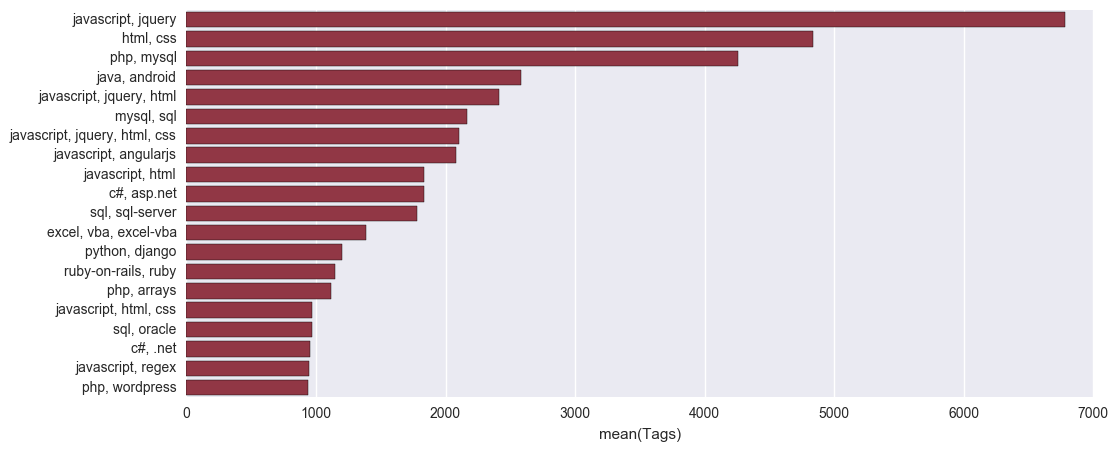

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(x=stack_tags_new.loc[stack_tags_new["Tags"].apply(lambda x: (", "in x)), "Tags"].value_counts()[:20], 
            y=stack_tags_new.loc[stack_tags_new["Tags"].apply(lambda x: (", "in x)), "Tags"].value_counts()[:20].index, 
            color="#A0283A", orient="horizontal")

#  

# 2. Constructing Tokenizer and Traditional Clustering

## 2.1. Defining Stop Words, Lemmatizing and Normalizing Text using Spacy and Gensim

In [31]:
# sample_text = stack_questions_cleaned.sample(n=10000)
%store -r sample_text

In [32]:
# sentence = pd.Series(converting_token_to_trigram_sentences(sample_text, "Text for Analysis (Title + Body Exc. Code)"), index=sample_text.index).apply(lambda x: " ".join(x))
# sample_text["Text for Analysis"] = sentence

In [33]:
print_original_and_tokenized(sample_text["Text for Analysis"])

Current index: 5874

Original: insert sound audio have database contain listview picture want include each each voice datum have error follow java xml database.java

Tokenized: ['insert', 'sound', 'audio', 'have', 'database', 'contain', 'listview', 'picture', 'want', 'include', 'each', 'each', 'voice', 'datum', 'have', 'error', 'follow', 'java', 'xml', 'database.java']

Finalized: ['insert', 'sound', 'audio', 'have', 'database', 'contain', 'listview', 'picture', 'want', 'include', 'each', 'each', 'voice', 'datum', 'have', 'error', 'follow', 'java', 'xml', 'database.java']

After Removing Stop Words: ['insert', 'sound', 'audio', 'database', 'listview', 'picture', 'voice', 'java', 'xml', 'database.java']


## 2.2. Defining Vectorizer and Obtaining Document-Term Matrix

In [34]:
vect_idf = TfidfVectorizer(min_df=20, max_df=0.8, stop_words=TOTAL_STOP_WORDS, tokenizer=remove_stop_words)

In [35]:
dtm_idf = vect_idf.fit_transform(sample_text["Text for Analysis"])

In [36]:
dtm_idf_df = pd.DataFrame(dtm_idf.toarray(), columns=vect_idf.get_feature_names(), index=sample_text.index)
dtm_idf_df.head(5)

,ability,absolute,absolutely,acce,accessible,account,activate,active,activity,adapt,...,worker,worth,would_love,wrapper,xaml,xcode,xml,xml_file,yesterday,zoom
Id,,,,,,,,,,,,,,,,,,,,,
25677620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34670240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10779020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18389310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33531070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print(list(vect_idf.get_feature_names())[:100])
print(list(vect_idf.get_feature_names())[:981:-1])

['ability', 'absolute', 'absolutely', 'acce', 'accessible', 'account', 'activate', 'active', 'activity', 'adapt', 'adapter', 'addition', 'addr', 'addre', 'addres', 'adjust', 'admin', 'administrator', 'advanced', 'affect', 'ajax', 'ajax_call', 'alert', 'algorithm', 'alia', 'align', 'allocate', 'alter', 'amazon', 'amp', 'amp_amp', 'analysi', 'anchor', 'android', 'android_app', 'android_application', 'android_studio', 'angular', 'angularj', 'animate', 'animation', 'annotation', 'apache', 'api', 'apology', 'app', 'app_crash', 'apple', 'approach', 'appropriate', 'arbitrary', 'architecture', 'arraylist', 'arrow', 'article', 'asp.net', 'asp.net_application', 'aspect', 'assembly', 'asset', 'assign', 'assignment', 'associate', 'associate_with', 'association', 'async', 'asynchronous', 'attach', 'audio', 'authenticate', 'authentication', 'author', 'authorization', 'auto', 'autocomplete', 'automate', 'automatic', 'avail', 'average', 'aware', 'azure', 'backend', 'background', 'background_color', 'b

In [38]:
dtm_idf_df_norm = pd.DataFrame(normalize(dtm_idf_df), index=dtm_idf_df.index, columns=dtm_idf_df.columns)
dtm_idf_df_norm.head()

,ability,absolute,absolutely,acce,accessible,account,activate,active,activity,adapt,...,worker,worth,would_love,wrapper,xaml,xcode,xml,xml_file,yesterday,zoom
Id,,,,,,,,,,,,,,,,,,,,,
25677620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34670240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10779020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18389310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33531070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3. Running K-Means Clustering and t-SNE Visualization

In [39]:
clusters_idf = get_clusters(dtm_idf_df_norm, sample_text.index, 7)
clusters_idf_df = pd.DataFrame(clusters_idf)
clusters_idf_df.columns = ["Cluster"]
sample_text_new_cluster = sample_text.join(pd.DataFrame(clusters_idf_df), how="left")

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=37855, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


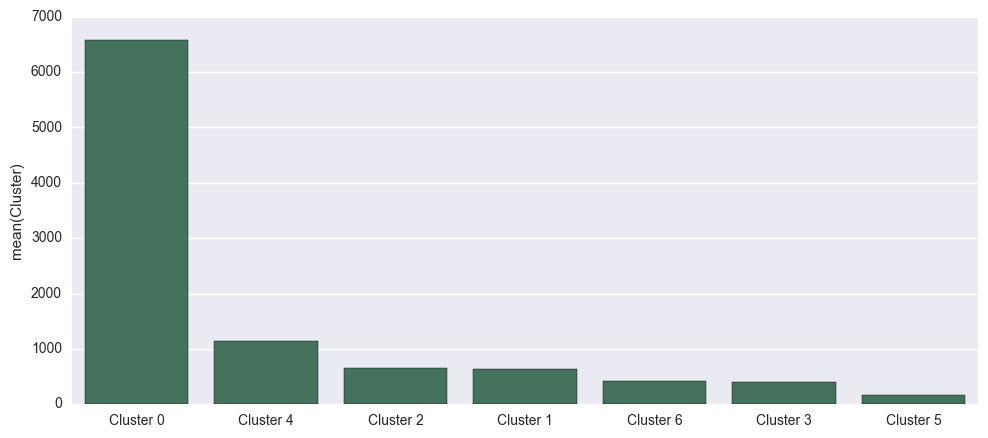

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=sample_text_new_cluster["Cluster"].value_counts(), x=sample_text_new_cluster["Cluster"].value_counts().index, 
            color="#3E795C")

In [41]:
rank = 1
for index in pd.DataFrame(sample_text_new_cluster["Cluster"].value_counts()).index:
    print(index + " (Rank " + str(rank) + "): ")
    return_top_n_words(dtm_idf_df, index, clusters_idf, 30)
    rank += 1

Cluster 0 (Rank 1): 
database display field url link property model content folder compile acce store directory request service format client api event default site module reference path system plugin figure website control handle
Cluster 4 (Rank 2): 
app button android activity eclipse server display fragment screen api store click acce android_app background database link layout service crash connect launch listview login phone facebook xml exception develop when_click
Cluster 2 (Rank 3): 
javascript jquery link execute content ajax click event button browser display hide plugin json website site document url style render server console figure format alert bootstrap height parse property checkbox
Cluster 1 (Rank 4): 
query database field mysql sql insert display join store sql_server sql_query model group primary cell delete foreign html format customer retrieve sort link statement trigger product category mysql_query structure duplicate
Cluster 6 (Rank 5): 
parameter field password 

In [42]:
# count_idf_tsne = get_tsne_from_dtm(dtm_idf, dtm_idf_df)
%store -r count_idf_tsne

In [43]:
count_idf_tsne_df = pd.DataFrame(count_idf_tsne, index=sample_text.index, columns=['x', 'y'])
count_idf_tsne_df["Cluster"] = clusters_idf

In [44]:
count_idf_tsne_df.head(5)

,x,y,Cluster
Id,,,
25677620,-0.508785,5.047185,Cluster 2
34670240,1.367816,5.935806,Cluster 0
10779020,-0.330033,0.497653,Cluster 0
18389310,-0.994484,1.971171,Cluster 0
33531070,-1.925290,5.528073,Cluster 0


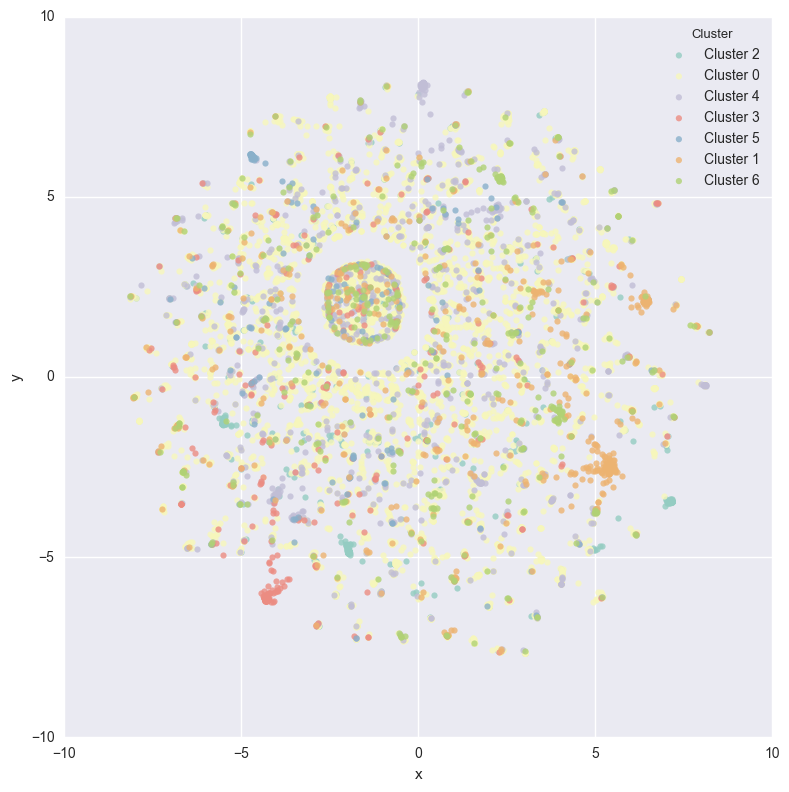

In [45]:
sns.lmplot("x", "y", data=count_idf_tsne_df, hue="Cluster", fit_reg=False, aspect=1.0, size=8, legend_out=False)

In [46]:
sample_text_new_cluster["Tf-idf Score"] = dtm_idf_df.sum(axis=1)

In [47]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 0", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
784010,Cluster 0,What is the most practical Solution to Data Ma...,What is the most practical Solution to Data Ma...,6.538302
11118030,Cluster 0,Describe the transition to SaaS model,Describe the transition to SaaS model What is...,5.898466
37333900,Cluster 0,WebRTC DataChannel: working in Firefox but not...,WebRTC DataChannel: working in Firefox but not...,5.797566
8387880,Cluster 0,Internet Explorer PDF Reader,Internet Explorer PDF Reader I apologize for ...,5.788285
25275070,Cluster 0,Export an `OBJC_CLASS` from one static lib as ...,Export an `OBJC_CLASS` from one static lib as ...,5.766793


In [48]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 1", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
1654140,Cluster 1,ORM/Persistence layer Advice,ORM/Persistence layer Advice Hi all I'm star...,5.302265
25438730,Cluster 1,Workflow for a basic database query webapp,Workflow for a basic database query webapp I'...,5.263815
1099430,Cluster 1,Returning A Value To a Swing Class from anothe...,Returning A Value To a Swing Class from anothe...,4.998198
23314530,Cluster 1,Big data indexing advice on SQL Server,Big data indexing advice on SQL Server I am a...,4.490845
34121650,Cluster 1,Add box-shadow to tbody in CSS?,Add box-shadow to tbody in CSS? I am trying t...,4.356560


In [49]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 2", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
32131580,Cluster 2,Breakpoints not hit in javascript files in Vis...,Breakpoints not hit in javascript files in Vis...,5.268712
10108410,Cluster 2,HTML5 video capture and streaming?,HTML5 video capture and streaming? I'm workin...,4.999396
11596500,Cluster 2,formPanel inside a button in extjs 3.4,formPanel inside a button in extjs 3.4 after ...,4.871430
5856030,Cluster 2,Asynchronous client javascript process to talk...,Asynchronous client javascript process to talk...,4.656590
9607880,Cluster 2,PHP HTML5 to PDF converter needed,PHP HTML5 to PDF converter needed I know this...,4.612141


In [50]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 3", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
5339100,Cluster 3,How to map 2D coordinates from store image to ...,How to map 2D coordinates from store image to ...,4.300485
3277180,Cluster 3,Image uploading with PHP,Image uploading with PHP I've been building a...,4.279909
13497700,Cluster 3,PHP libgd crash without feedback,PHP libgd crash without feedback I'm working ...,4.262210
29181440,Cluster 3,android animating views between pages,android animating views between pages I have ...,4.243277
34771860,Cluster 3,Menu content does not fit in mobile mode,Menu content does not fit in mobile mode The ...,4.234054


In [51]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 4", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
18706970,Cluster 4,What could cause a sudden ClassNotFoundExcepti...,What could cause a sudden ClassNotFoundExcepti...,6.144948
37015510,Cluster 4,trying to create a directory in my bitnami odo...,trying to create a directory in my bitnami odo...,5.384007
1969800,Cluster 4,Web service fails (401 Unauthorized) on one se...,Web service fails (401 Unauthorized) on one se...,4.879934
4927760,Cluster 4,"Heavy php operations in an http request, reali...","Heavy php operations in an http request, reali...",4.718923
6325500,Cluster 4,m2eclipse/Eclipse/WTP: Create a container proj...,m2eclipse/Eclipse/WTP: Create a container proj...,4.626228


In [52]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 5", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
10633830,Cluster 5,Should the AWS Token Vending Machine be deploy...,Should the AWS Token Vending Machine be deploy...,5.383726
11309950,Cluster 5,Control Bluetooth audio device with iPhone,Control Bluetooth audio device with iPhone I ...,5.295024
22130460,Cluster 5,android application and communication with ast...,android application and communication with ast...,4.721719
31279660,Cluster 5,Android - ImageView - Multiple Screen Support ...,Android - ImageView - Multiple Screen Support ...,4.417362
37680890,Cluster 5,Bower + private-bower + TFS (self hosted) with...,Bower + private-bower + TFS (self hosted) with...,4.347478


In [53]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 6", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
13475900,Cluster 6,Implement custom security/filters on a part of...,Implement custom security/filters on a part of...,4.809047
4437660,Cluster 6,How do I modify WCF to process messages in a d...,How do I modify WCF to process messages in a d...,4.694696
7352360,Cluster 6,How can I force a commit on the current row fr...,How can I force a commit on the current row fr...,4.434761
534870,Cluster 6,Zend Form: How do I make it bend to my will?,Zend Form: How do I make it bend to my will? ...,4.414888
1129020,Cluster 6,SSL WCFs with custom binding,SSL WCFs with custom binding Has anyone ever ...,4.413333


#  

# 3. Implementing Latent Dirichlet Allocation (LDA)

# 3.1. Summarizing Phrases and Building Dictionary from Text

## 3.1.1 Python Questions and Answers

In [54]:
# python_questions_sentences = pd.Series(converting_token_to_trigram_sentences(python_questions_cleaned, "Text for Analysis (Title + Body Exc. Code)"), index=python_questions_cleaned.index).apply(lambda x: " ".join(x))
# python_answers_sentences = pd.Series(converting_token_to_trigram_sentences(python_answers_cleaned, "Body Exc. Code"), index=python_answers_cleaned.index).apply(lambda x: " ".join(x))
# python_questions_sentences_cleaned_list = list(python_questions_sentences.apply(remove_stop_words))
# python_answers_sentences_cleaned_list = list(python_answers_sentences.apply(remove_stop_words))

In [55]:
# python_questions_sentences_cleaned_dict = Dictionary(python_questions_sentences_cleaned_list)
# python_answers_sentences_cleaned_dict = Dictionary(python_answers_sentences_cleaned_list)

In [56]:
# python_questions_doc_term_matrix = [python_questions_sentences_cleaned_dict.doc2bow(doc) for doc in python_questions_sentences_cleaned_list]
# python_answers_doc_term_matrix = [python_answers_sentences_cleaned_dict.doc2bow(doc) for doc in python_answers_sentences_cleaned_list]

## 3.1.2. StackOverflow Questions and Answers

In [57]:
# Removing some of the stop words before proceeding
# stack_questions_sentences = pd.Series(converting_token_to_trigram_sentences(stack_questions_cleaned, "Text for Analysis (Title + Body Exc. Code)"), index=stack_questions_cleaned.index).apply(lambda x: " ".join(x))
# stack_answers_sentences = pd.Series(converting_token_to_trigram_sentences(stack_answers_cleaned, "Body Exc. Code"), index=stack_answers_cleaned.index).apply(lambda x: " ".join(x))
# stack_questions_sentences_cleaned_list = list(stack_questions_sentences.apply(remove_stop_words))
# stack_answers_sentences_cleaned_list = list(stack_answers_sentences.apply(remove_stop_words))

In [58]:
# stack_questions_sentences_cleaned_dict = Dictionary(stack_questions_sentences_cleaned_list)
# stack_answers_sentences_cleaned_dict = Dictionary(stack_answers_sentences_cleaned_list)
# stack_questions_doc_term_matrix = [stack_questions_sentences_cleaned_dict.doc2bow(doc) for doc in stack_questions_sentences_cleaned_list]
# stack_answers_doc_term_matrix = [stack_answers_sentences_cleaned_dict.doc2bow(doc) for doc in stack_answers_sentences_cleaned_list]

# 3.2. Topic Modelling and KMeans Clustering by Cosine Similarity

# 3.2.1. Python Questions and Answers

## 3.2.1.1. Building LDA Models

In [59]:
# python_questions_lda = LdaMulticore(python_questions_doc_term_matrix, num_topics=30, id2word=python_questions_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# python_answers_lda = LdaMulticore(python_answers_doc_term_matrix, num_topics=30, id2word=python_answers_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# python_questions_lda_vis = pyLDAvis.gensim.prepare(python_questions_lda, python_questions_doc_term_matrix, python_questions_sentences_cleaned_dict)
# python_answers_lda_vis = pyLDAvis.gensim.prepare(python_answers_lda, python_answers_doc_term_matrix, python_answers_sentences_cleaned_dict)

## 3.2.1.2. Visualizing Models

In [60]:
pyLDAvis.display(python_questions_lda_vis)

In [61]:
pyLDAvis.display(python_answers_lda_vis)

# 3.2.2. StackOverflow Questions and Answers

## 3.2.2.1. Building LDA Models

In [62]:
# stack_answers_lda = LdaMulticore(stack_answers_doc_term_matrix, num_topics=30, id2word=stack_answers_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# stack_questions_lda = LdaMulticore(stack_questions_doc_term_matrix, num_topics=30, id2word=stack_questions_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# stack_answers_lda_vis = pyLDAvis.gensim.prepare(stack_answers_lda, stack_answers_doc_term_matrix, stack_answers_sentences_cleaned_dict)
# stack_questions_lda_vis = pyLDAvis.gensim.prepare(stack_questions_lda, stack_questions_doc_term_matrix, stack_questions_sentences_cleaned_dict)

## 3.2.2.2. Visualizing Models

In [63]:
pyLDAvis.display(stack_questions_lda_vis)

In [64]:
pyLDAvis.display(stack_answers_lda_vis)

# 4. NLTK and Scikit-Learn K-Means Clustering

# 4.1. Trial Stage with NLTK and Scikit-Learn K-Means

In [65]:
# sample_df = python_question_topic_df.sample(n=50000).reset_index().drop("index", axis=1)
# sample_matrix = [element for element in sample_df.as_matrix()]
%store -r sample_df
sample_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.032634,0.000000,0.0,0.624983,0.0,0.0,0.044332,0.0,0.072424,0.000000,...,0.0,0.0,0.022208,0.000000,0.000000,0.074231,0.000000,0.000000,0.000000,0.043262
1,0.292495,0.055323,0.0,0.055928,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.115376,0.000000,0.000000,0.000000,0.160965,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.129167,0.000000,0.379024,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.425305,...,0.0,0.0,0.000000,0.000000,0.160844,0.285280,0.000000,0.000000,0.000000,0.000000
4,0.806667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 4.1.1. NLTK Clustering by Cosine Similarity

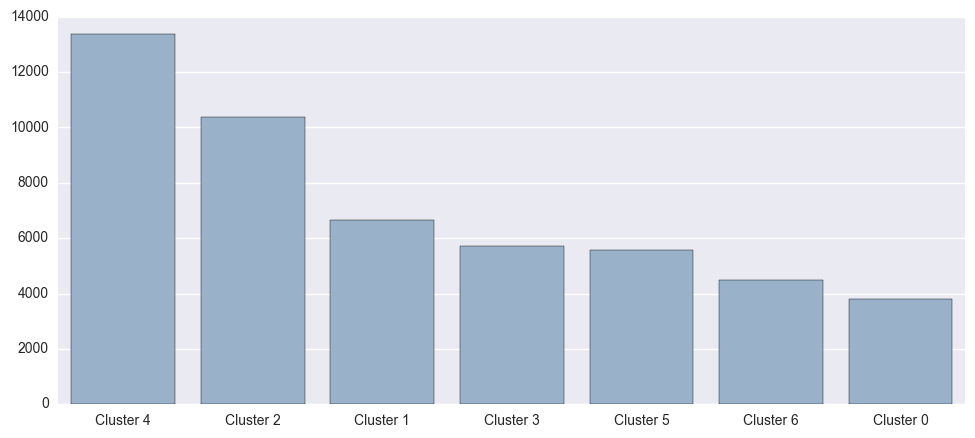

In [66]:
# clusters_nltk = get_clusters_new(sample_matrix, sample_df, 7, 1)
%store -r clusters_nltk
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=clusters_nltk.value_counts(), x=clusters_nltk.value_counts().index, 
            color="#91B2D2")

## 4.1.2. Scikit-Learn Clustering by Normalized Euclidean Distance

In [67]:
sample_df_norm = pd.DataFrame(normalize(sample_df), index=sample_df.index, columns=sample_df.columns)
sample_df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.05101,0.000000,0.0,0.976919,0.0,0.0,0.069297,0.0,0.113208,0.000000,...,0.0,0.0,0.034714,0.000000,0.000000,0.116032,0.000000,0.000000,0.000000,0.067624
1,0.72004,0.136189,0.0,0.137679,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.284021,0.000000,0.000000,0.000000,0.396249,0.000000,0.000000
2,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.262731,0.000000,0.770953,0.000000
3,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.792317,...,0.0,0.0,0.000000,0.000000,0.299642,0.531459,0.000000,0.000000,0.000000,0.000000
4,1.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=32432, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


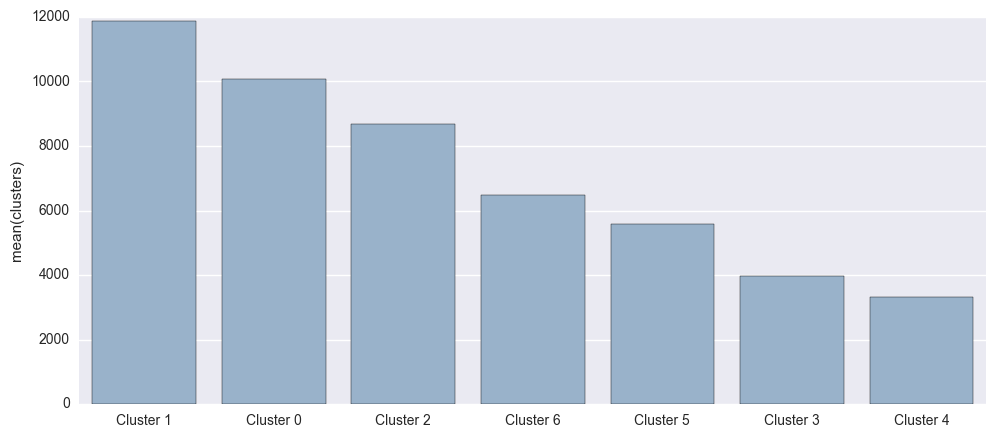

In [68]:
clusters_kmeans_norm = get_clusters(sample_df_norm, sample_df_norm.index, n_cluster=7, random_state=32432)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=clusters_kmeans_norm.value_counts(), x=clusters_kmeans_norm.value_counts().index, 
            color="#91B2D2")

# 4.2. K-Means

In [69]:
# python_question_topic_df = get_topic_distribution(python_questions_lda, python_questions_doc_term_matrix)
# python_question_topic_df.fillna(0, inplace=True)
python_question_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.205269,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.172751,0.0,0.461577,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.129167,0.000000,0.129167,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.173357,0.000000,0.0,0.000000,0.0,0.454321,0.259033
3,0.0,0.0,0.0,0.0,0.0,0.081712,0.241309,0.355622,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.157925,0.415934,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [70]:
# python_answer_topic_df = get_topic_distribution(python_answers_lda, python_answers_doc_term_matrix)
# python_answer_topic_df.fillna(0, inplace=True)
python_answer_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.205199,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.172756,0.0,0.461639,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.129167,0.000000,0.129167,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.173341,0.000000,0.0,0.000000,0.0,0.454323,0.259038
3,0.0,0.0,0.0,0.0,0.0,0.081698,0.241302,0.355785,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.157932,0.415924,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [71]:
# stack_question_topic_df = get_topic_distribution(stack_questions_lda, stack_questions_doc_term_matrix)
# stack_question_topic_df.fillna(0, inplace=True)
stack_question_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.205185,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.172757,0.0,0.461651,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.129167,0.000000,0.129167,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.173344,0.000000,0.0,0.000000,0.0,0.454290,0.259068
3,0.0,0.0,0.0,0.0,0.0,0.081748,0.241330,0.355191,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.157937,0.415917,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [72]:
# stack_answer_topic_df = get_topic_distribution(stack_answers_lda, stack_answers_doc_term_matrix)
# stack_answer_topic_df.fillna(0, inplace=True)
stack_answer_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.205327,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.172747,0.0,0.461526,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.129167,0.000000,0.129167,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.173388,0.000000,0.0,0.000000,0.0,0.454282,0.259059
3,0.0,0.0,0.0,0.0,0.0,0.081741,0.241326,0.355266,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.157933,0.415924,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


# 4.2.1. Python Questions and Answers

## 4.2.1.1. Python Questions

In [73]:
# python_question_topic_df_norm = return_normalized_df(python_question_topic_df)
python_question_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.379343,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.319249,0.0,0.853008,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.234177,0.000000,0.234177,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.312468,0.000000,0.0,0.000000,0.0,0.818894,0.466896


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=85191, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


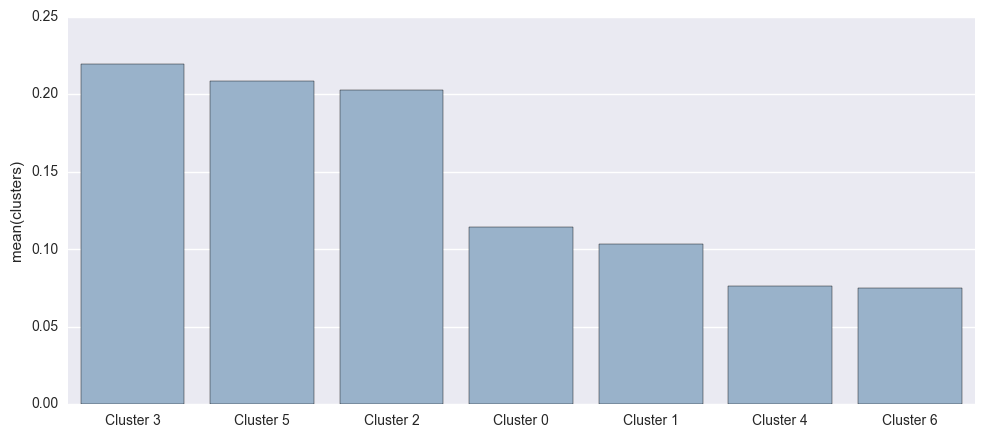

In [74]:
python_question_clusters = get_clusters(python_question_topic_df_norm, python_question_topic_df_norm.index, n_cluster=7, random_state=85191)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=python_question_clusters.value_counts()/python_question_clusters.value_counts().sum(), x=python_question_clusters.value_counts().index.astype(str), 
            color="#91B2D2")

In [75]:
# python_question_topic_df_pca = get_pca(python_question_topic_df)
python_question_topic_df_pca["Cluster"] = python_question_clusters
python_question_topic_df_pca.head()

,x,y,Cluster
0,-0.006901,0.043061,Cluster 5
1,0.064896,0.015615,Cluster 5
2,0.012079,0.020537,Cluster 5
3,-0.055510,-0.038660,Cluster 3
4,-0.035339,0.074197,Cluster 5


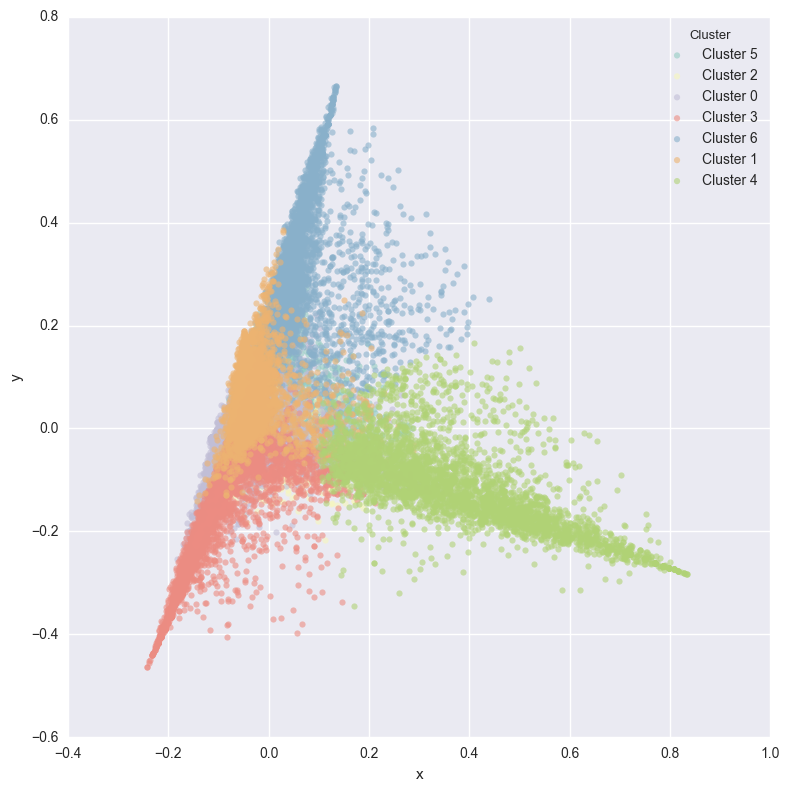

In [76]:
sns.lmplot(y="y", x="x", data=python_question_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

In [77]:
print("Top Topics in Clusters Ranked by Percentage: ")
for index in python_question_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(python_questions_lda, python_question_topic_df, python_question_clusters, int(index[-1]), 3)

Top Topics in Clusters Ranked by Percentage: 
Cluster 3: 
['plot', 'matplotlib', 'matrix', 'graph', 'figure', 'coordinate', 'vector', 'shape', 'color', 'chart']
['dictionary', 'extract', 'parse', 'document', 'cell', 'pair', 'product', 'beautifulsoup', 'iterate_through', 'format']
['feature', 'assign', 'dataset', 'sample', 'tensorflow', 'slice', 'train', 'scikit_learn', 'training', 'sklearn']
Cluster 5: 
['link', 'html', 'website', 'selenium', 'url', 'email', 'scrapy', 'anaconda', 'javascript', 'webpage']
['server', 'panda', 'client', 'connect', 'connection', 'socket', 'port', 'device', 'ipython', 'proxy']
['request', 'execute', 'header', 'exit', 'execution', 'generator', 'worker', 'flag', 'chunk', 'kill']
Cluster 2: 
['group', 'numpy', 'numpy_array', 'datum_frame', 'digit', 'matlab', 'mode', 'frequency', 'maximum', 'book']
['dataframe', 'xml', 'structure', 'level', 'serie', 'modify', 'skip', 'list_comprehension', 'pythonic', 'concatenate']
['csv', 'compare', 'repeat', 'fast', 'combinat

## 4.2.1.2. Python Answers

In [78]:
# python_answer_topic_df_norm = return_normalized_df(python_answer_topic_df)
python_answer_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.379194,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.319242,0.0,0.853078,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.234177,0.000000,0.234177,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.312439,0.000000,0.0,0.000000,0.0,0.818897,0.466905


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=20579, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


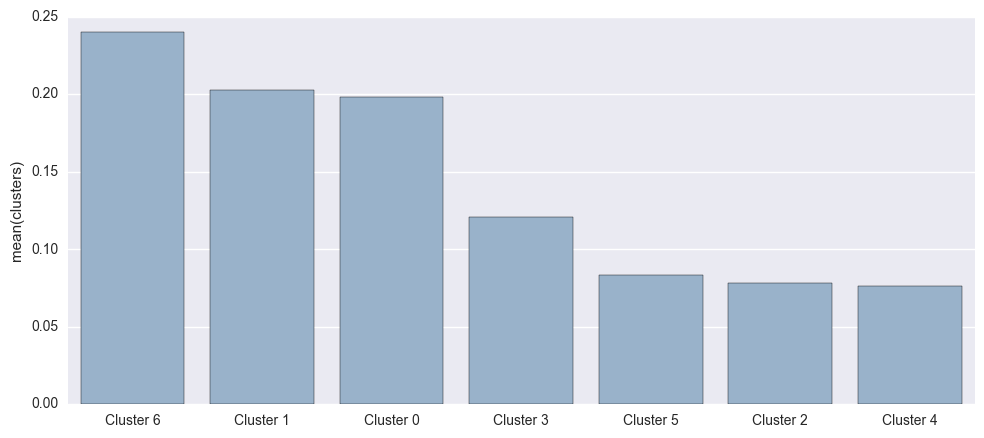

In [79]:
python_answers_clusters = get_clusters(python_question_topic_df_norm, python_question_topic_df_norm.index, n_cluster=7, random_state=20579)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=python_answers_clusters.value_counts()/python_answers_clusters.value_counts().sum(), x=python_answers_clusters.value_counts().index.astype(str), 
            color="#91B2D2")

In [80]:
# python_answer_topic_df_pca = get_pca(python_answer_topic_df)
python_answer_topic_df_pca["Cluster"] = python_answers_clusters
python_answer_topic_df_pca.head()

,x,y,Cluster
0,-0.006271,0.044084,Cluster 3
1,0.064073,0.015899,Cluster 6
2,0.014098,0.021174,Cluster 3
3,-0.054962,-0.039856,Cluster 0
4,-0.035017,0.071836,Cluster 1


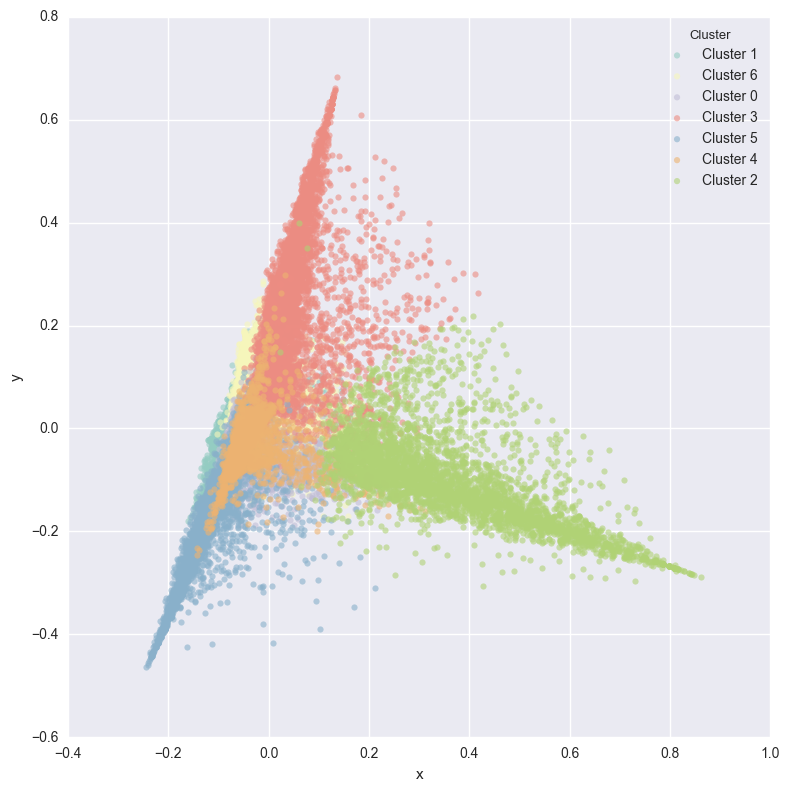

In [81]:
sns.lmplot(y="y", x="x", data=python_answer_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

In [82]:
print("Top Topics in Clusters Ranked by Percentage: ")
for index in python_answers_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(python_answers_lda, python_answer_topic_df, python_answers_clusters, int(index[-1]), 3)

Top Topics in Clusters Ranked by Percentage: 
Cluster 6: 
['request', 'url', 'byte', 'unicode', 'header', 'encode', 'browser', 'session', 'javascript', 'encoding']
['syntax', 'expression', 'evaluate', 'keyword', 'style', 'extend', 'round', 'indent', 'decimal', 'incorrect']
['app', 'iterable', 'table', 'iterator', 'console', 'ipython', 'debug', 'screen', 'video', 'batch']
Cluster 1: 
['dictionary', 'compare', 'entry', 'unique', 'pair', 'duplicate', 'reverse', 'comparison', 'store', 'symbol']
['level', 'assign', 'bind', 'scope', 'declare', 'nest', 'namespace', 'callback', 'rule', 'mysql']
['space', 'figure', 'plot', 'frame', 'insert', 'matplotlib', 'color', 'anaconda', 'groupby', 'patch']
Cluster 0: 
['parameter', 'sample', 'matrix', 'vector', 'random', 'shape', 'coordinate', 'stack', 'weight', 'dtype']
['approach', 'parse', 'condition', 'generator', 'algorithm', 'csv', 'counter', 'tree', 'merge', 'repeat']
['api', 'widget', 'display', 'button', 'control', 'click', 'interface', 'gui', 't

## 4.2.1.3. StackOverflow Questions and Answers

In [83]:
# stack_question_topic_df_norm = return_normalized_df(stack_question_topic_df)
stack_question_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.379163,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.319241,0.0,0.853092,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.234177,0.000000,0.234177,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.312452,0.000000,0.0,0.000000,0.0,0.818855,0.466968


In [84]:
# stack_answer_topic_df_norm = return_normalized_df(stack_answer_topic_df)
stack_answer_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.379467,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.319254,0.0,0.852951,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.234177,0.000000,0.234177,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.312532,0.000000,0.0,0.000000,0.0,0.818841,0.466953


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=66675, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=18195, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


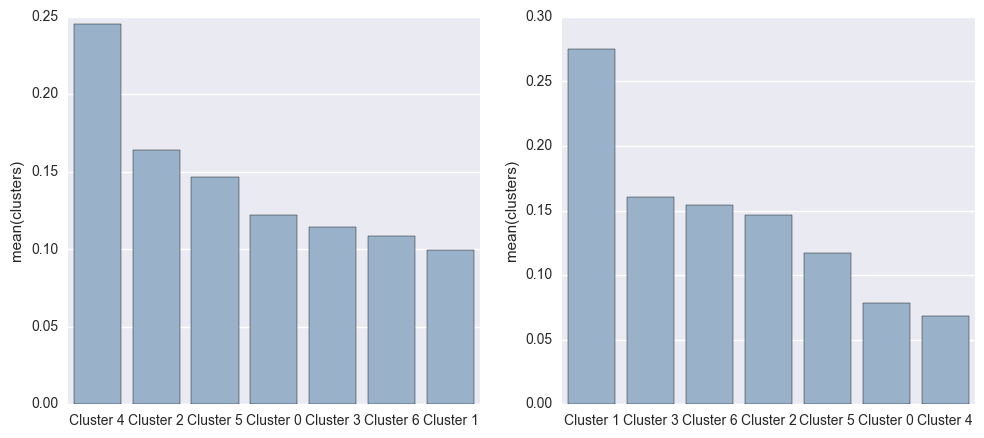

In [85]:
stack_questions_clusters = get_clusters(stack_question_topic_df_norm, stack_question_topic_df_norm.index, n_cluster=7, random_state=66675)
stack_answers_clusters = get_clusters(stack_answer_topic_df_norm, stack_answer_topic_df_norm.index, n_cluster=7, random_state=18195)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=stack_questions_clusters.value_counts()/stack_questions_clusters.value_counts().sum(), x=stack_questions_clusters.value_counts().index.astype(str), 
            color="#91B2D2", ax=ax[0])
sns.barplot(y=stack_answers_clusters.value_counts()/stack_answers_clusters.value_counts().sum(), x=stack_answers_clusters.value_counts().index.astype(str), 
            color="#91B2D2", ax=ax[1])

In [86]:
# stack_question_topic_df_pca = get_pca(stack_question_topic_df)
stack_question_topic_df_pca["Cluster"] = stack_questions_clusters
stack_question_topic_df_pca.head()

,x,y,Cluster
0,-0.008054,0.043041,Cluster 4
1,0.064267,0.023480,Cluster 6
2,0.014385,0.015993,Cluster 4
3,-0.056757,-0.035325,Cluster 5
4,-0.034685,0.076456,Cluster 4


In [87]:
# stack_answer_topic_df_pca = get_pca(stack_answer_topic_df)
stack_answer_topic_df_pca["Cluster"] = stack_answers_clusters
stack_answer_topic_df_pca.head()

,x,y,Cluster
0,-0.007311,0.039126,Cluster 6
1,0.064152,0.021659,Cluster 3
2,0.013853,0.014090,Cluster 6
3,-0.056300,-0.032544,Cluster 3
4,-0.035304,0.072644,Cluster 3


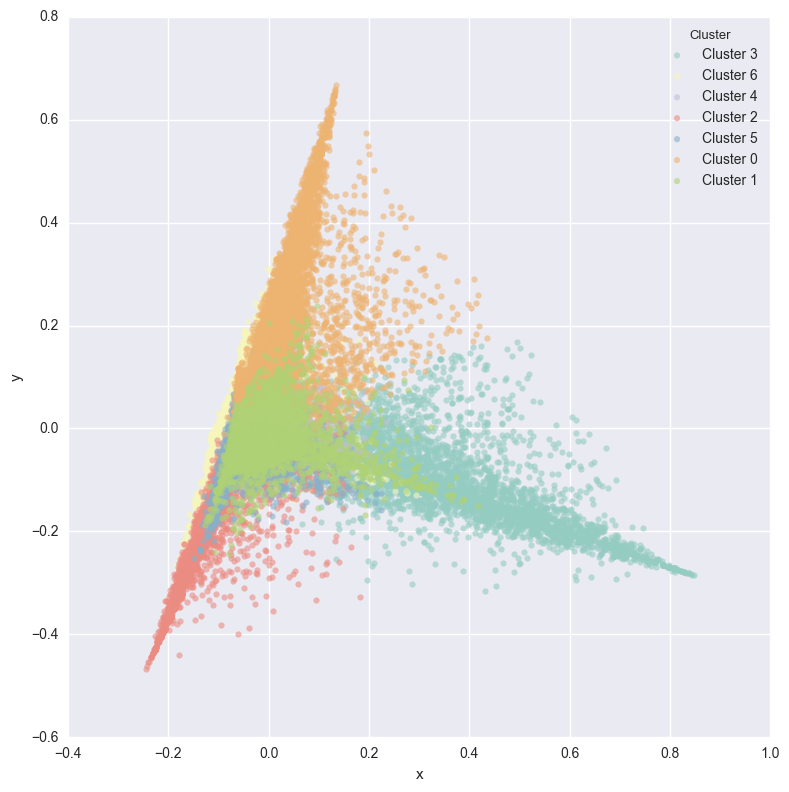

In [88]:
sns.lmplot(y="y", x="x", data=stack_question_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

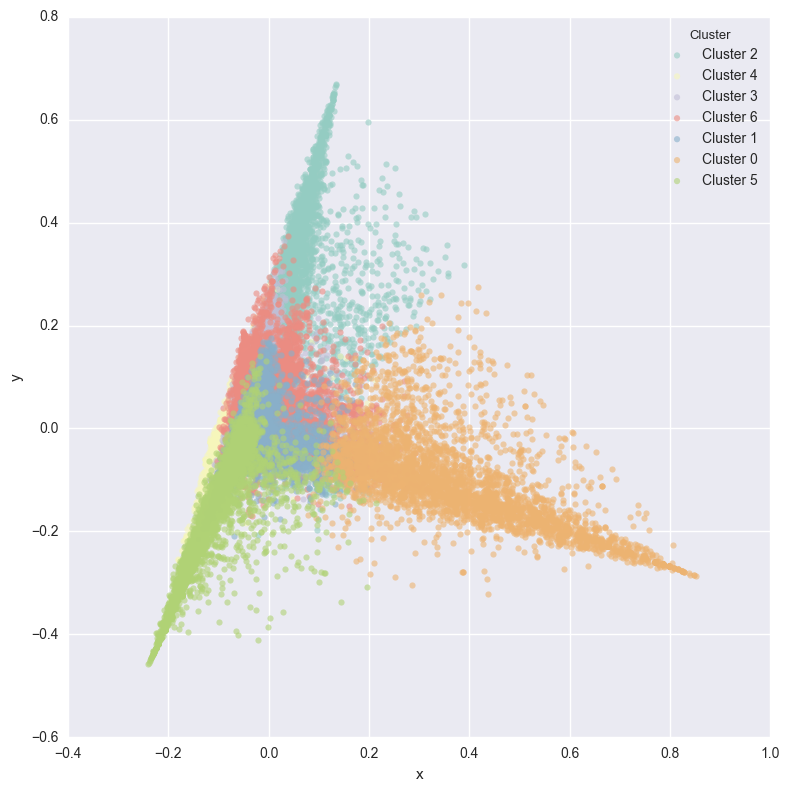

In [89]:
sns.lmplot(y="y", x="x", data=stack_answer_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

In [90]:
print("Top Topics in Clusters Ranked by Percentage (Questions): ")
for index in stack_questions_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(stack_questions_lda, stack_question_topic_df, stack_questions_clusters, int(index[-1]), 3)

Top Topics in Clusters Ranked by Percentage (Questions): 
Cluster 4: 
['sort', 'parse', 'extract', 'language', 'bootstrap', 'regex', 'split', 'pattern', 'dictionary', 'syntax']
['path', 'compile', 'resource', 'source', 'eclipse', 'configuration', 'spring', 'dependency', 'debug', 'deploy']
['block', 'directory', 'rail', 'detect', 'ruby', 'hash', 'linux', 'hover', 'ubuntu', 'terminal']
Cluster 2: 
['table', 'cell', 'excel', 'scroll', 'join', 'entry', 'sheet', 'customer', 'macro', 'primary']
['node', 'session', 'collection', 'tree', 'servlet', 'foreach', 'photo', 'ember', 'cakephp', 'linq']
['javascript', 'control', 'child', 'parent', 'submit', 'validation', 'html', 'alert', 'validate', 'curl']
Cluster 5: 
['link', 'jquery', 'ajax', 'chrome', 'html', 'angularj', 'href', 'click', 'dialog', 'refresh']
['store', 'product', 'memory', 'pointer', 'byte', 'algorithm', 'random', 'fast', 'approach', 'unique']
['interface', 'declare', 'implementation', 'constructor', 'merge', 'initialize', 'reposit

In [91]:
print("Top Topics in Clusters Ranked by Percentage (Answers): ")
for index in stack_answers_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(stack_answers_lda, stack_answer_topic_df, stack_answers_clusters, int(index[-1]), 3)

Top Topics in Clusters Ranked by Percentage (Answers): 
Cluster 1: 
['reference', 'copy', 'modify', 'commit', 'branch', 'merge', 'export', 'head', 'master', 'paste']
['compile', 'exception', 'compiler', 'quote', 'operator', 'instruction', 'catch', 'boolean', 'runtime', 'symbol']
['table', 'query', 'field', 'group', 'join', 'sql', 'database', 'unique', 'entry', 'insert']
Cluster 3: 
['image', 'cache', 'compare', 'hash', 'algorithm', 'scale', 'pixel', 'screen', 'dimension', 'chart']
['statement', 'address', 'entity', 'dependency', 'register', 'status', 'domain', 'transaction', 'spring', 'annotation']
['python', 'extension', 'expression', 'sequence', 'evaluate', 'graph', 'terminal', 'bash', 'root', 'edge']
Cluster 6: 
['node', 'memory', 'space', 'span', 'stack', 'buffer', 'structure', 'tree', 'console.log', 'store']
['source', 'service', 'system', 'location', 'stream', 'download', 'flag', 'configuration', 'binary', 'linux']
['approach', 'static', 'language', 'rule', 'pattern', 'implementa

# 5. Doc2Vec for Further Insights